# Instacart Analysis

In [1]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:90% !important; }</style>"))


/var/folders/mg/hptp2zld5cl6kjcrwfys_p5h0000gn/T/ipykernel_58979/3609150076.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Introduction

Instacart is a Groceries Delivery App, where customers can place a grocery order and have it delivered to them. The purpose of this analysis is to provide general insight into the shopping habits of Instacart Customers. For the analysis, we will be using tables with data on orders, products, products ordered, aisles and departments. 

## 1. Data Cleaning and Preprocessing

We'll begin by loading the data and importing necessary libraries. Then we'll address different data aspects such as data types, missing values, and duplicates.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


orders = pd.read_csv('instacart_orders.csv', sep=';')

products = pd.read_csv('products.csv', sep=';')

aisles =  pd.read_csv('aisles.csv', sep=';')

departments =  pd.read_csv('departments.csv', sep=';')

order_products =  pd.read_csv('order_products.csv', sep=';')

### 1.1 Orders Table

In [3]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478967 entries, 0 to 478966
Data columns (total 6 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                478967 non-null  int64  
 1   user_id                 478967 non-null  int64  
 2   order_number            478967 non-null  int64  
 3   order_dow               478967 non-null  int64  
 4   order_hour_of_day       478967 non-null  int64  
 5   days_since_prior_order  450148 non-null  float64
dtypes: float64(1), int64(5)
memory usage: 21.9 MB


In [4]:
orders.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1515936,183418,11,6,13,30.0
1,1690866,163593,5,5,12,9.0
2,1454967,39980,4,5,19,2.0
3,1768857,82516,56,0,20,10.0
4,3007858,196724,2,4,12,17.0


Although `order_id` and `user_id` are represented by numbers, we'll change the data types to strings, so that they explicitly show that they are categories rather than numerical values.

In [5]:
orders['order_id'] = orders['order_id'].astype(str)
orders['user_id'] = orders['user_id'].astype(str)

The `orders` table only contains null values in the `days_since_prior_order` column, which might refer to first orders. Wel'll verify that after checking for duplicates.

Since each order ID should appear only once, let's check for duplicates based on that:

In [6]:
# count how many times each order is in the table and filter those that appear more than once.
by_order = orders.groupby('order_id')['order_id'].count()  
repeated_ids = by_order[by_order > 1]
print('There are ', len(repeated_ids), ' duplicated IDs.')

orders[orders['order_id'].isin(repeated_ids.index)].sort_values(by='user_id').head(10)

There are  15  duplicated IDs.


,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
266232,1782114,106752,1,3,2,NaN
200059,1782114,106752,1,3,2,NaN
223105,2160484,107525,16,3,2,30.0
215294,2160484,107525,16,3,2,30.0
441599,2125197,14050,48,3,2,3.0
204042,2125197,14050,48,3,2,3.0
411408,1286742,183220,48,3,2,4.0
314427,1286742,183220,48,3,2,4.0
230807,1918001,188546,14,3,2,16.0
30371,1918001,188546,14,3,2,16.0


Let's drop those duplicated entires.

In [7]:
orders.drop_duplicates(inplace=True)

In [8]:
by_order = orders.groupby('order_id')['order_id'].count()  
repeated_ids = by_order[by_order > 1]

print('There are ', len(repeated_ids), ' duplicated IDs.')

There are  0  duplicated IDs.


Now let's go back to the number of days since the previous order. For the null values to refer to the first order, every null value should correspond only to order number 1. Likewise, every user id should only have one null value.

In [9]:
# Check whether null values correspond to an order number different than 1. 
# If all null values correspond to order number 1, the returned dataframe should be empty.
null_days = orders[orders['days_since_prior_order'].isna()]
print(null_days[null_days['order_number'] != 1])

Empty DataFrame
Columns: [order_id, user_id, order_number, order_dow, order_hour_of_day, days_since_prior_order]
Index: []


In [10]:
# Check the number of null values and first orders.
print('There are ', null_days.shape[0], " null values in the 'days_since_prior_order' column.")
first_order = orders[orders['order_number']==1]
print('There are ', first_order.shape[0], ' first orders.')

There are  28817  null values in the 'days_since_prior_order' column.
There are  28817  first orders.


In [11]:
# Check if each user_id has only one null value
null_cnt = orders.groupby('user_id')['days_since_prior_order'].apply(lambda x: x.isnull().sum())
null_cnt = null_cnt[null_cnt == 1]
print('There are ', len(null_cnt), ' users with only one null value')

There are  28817  users with only one null value


All the null values correspond to orders number one, and there are the same number of first orders as there are null values. Since the null values cannot be replaced with 0, we'll keep them as null and change the data type to integer.

In [12]:
orders['days_since_prior_order'] = orders['days_since_prior_order'].astype('Int64')
orders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 478952 entries, 0 to 478966
Data columns (total 6 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   order_id                478952 non-null  object
 1   user_id                 478952 non-null  object
 2   order_number            478952 non-null  int64 
 3   order_dow               478952 non-null  int64 
 4   order_hour_of_day       478952 non-null  int64 
 5   days_since_prior_order  450135 non-null  Int64 
dtypes: Int64(1), int64(3), object(2)
memory usage: 26.0+ MB


### 1.2 Products Table

In [13]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49694 entries, 0 to 49693
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49694 non-null  int64 
 1   product_name   48436 non-null  object
 2   aisle_id       49694 non-null  int64 
 3   department_id  49694 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [14]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


As with the previous table, we'll change the data type of the columns that are categories to strings.

In [15]:
products['product_id'] = products['product_id'].astype(str)
products['aisle_id'] = products['aisle_id'].astype(str)
products['department_id'] = products['department_id'].astype(str)

There are missing values for the `product_name` column.

In [16]:
noname_products = products[products['product_name'].isna()]
noname_products.sample(10)

,product_id,product_name,aisle_id,department_id
613,614,NaN,100,21
10904,10905,NaN,100,21
36859,36860,NaN,100,21
38316,38317,NaN,100,21
15780,15781,NaN,100,21
37584,37585,NaN,100,21
2374,2375,NaN,100,21
49483,49484,NaN,100,21
31979,31980,NaN,100,21
11892,11893,NaN,100,21


In [17]:
# Check to how many aisles and departments correspond the products with missing names.
print(noname_products['aisle_id'].nunique())
print(noname_products['department_id'].nunique())
print(noname_products['product_id'].nunique())

1
1
1258


Every product that is missing its name correspond to the same aisle and department. For now, we will assume that these products are awaiting for proper name or classification and we'll change their values to `Missing`.

In [18]:
products['product_name'] = products['product_name'].fillna('Missing')

In [19]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49694 entries, 0 to 49693
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49694 non-null  object
 1   product_name   49694 non-null  object
 2   aisle_id       49694 non-null  object
 3   department_id  49694 non-null  object
dtypes: object(4)
memory usage: 1.5+ MB


In [20]:
products.duplicated().sum()

0

There are no duplicated values, so we'll proceede with the next tables.

### 1.3 Aisles and Departments Tables

In [21]:
aisles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   aisle_id  134 non-null    int64 
 1   aisle     134 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB


In [22]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [23]:
departments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   department_id  21 non-null     int64 
 1   department     21 non-null     object
dtypes: int64(1), object(1)
memory usage: 464.0+ bytes


In [24]:
departments.sample(10)

,department_id,department
14,15,canned goods
2,3,bakery
5,6,international
20,21,missing
15,16,dairy eggs
0,1,frozen
3,4,produce
4,5,alcohol
9,10,bulk
8,9,dry goods pasta


As with the previous tables, we'll change the data types of the ids to strings.

In [25]:
aisles['aisle_id'] = aisles['aisle_id'].astype(str)
departments['department_id'] = departments['department_id'].astype(str)

Let's check the aisle and department that correspond to to the products that are missing their names.

In [26]:
aisles[aisles['aisle_id']=='100']

,aisle_id,aisle
99,100,missing


In [27]:
departments[departments['department_id']=='21']

,department_id,department
20,21,missing


Both the aisle and the department are tagged as `missing`. That explains the missing product names.

### 1.4 Ordered Products

In [28]:
order_products.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4545007 entries, 0 to 4545006
Data columns (total 4 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   order_id           4545007 non-null  int64  
 1   product_id         4545007 non-null  int64  
 2   add_to_cart_order  4544171 non-null  float64
 3   reordered          4545007 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 138.7 MB


In [29]:
order_products.sample(10)

,order_id,product_id,add_to_cart_order,reordered
1200382,2330933,29398,6.0,0
2578287,41691,15028,6.0,1
895788,2443183,47977,2.0,1
1699693,1813379,5479,3.0,1
3801508,283373,30720,10.0,0
1330402,2983311,40077,1.0,1
551141,1455897,21333,14.0,0
4048402,1727441,13829,25.0,1
668553,2020590,13948,2.0,0
2504023,2625471,30391,17.0,1


In [30]:
order_products['order_id'] = order_products['order_id'].astype(str)
order_products['product_id'] = order_products['product_id'].astype(str)

There are some missing values in `add_to_cart_order`. Let's take a look.

In [31]:
# Number of missing values 
order_products['add_to_cart_order'].isna().sum()

836

In [32]:
na_order = order_products[order_products['add_to_cart_order'].isna()]
na_order.sample(10)

,order_id,product_id,add_to_cart_order,reordered
2332300,1717990,1710,NaN,1
3070436,871281,20119,NaN,0
455854,1717990,20073,NaN,1
3782487,1713430,4855,NaN,1
3355181,3308010,22317,NaN,1
2670765,3308010,28398,NaN,1
3733118,2999801,9604,NaN,0
4222813,1800005,45116,NaN,0
2376645,1961723,41541,NaN,0
3984069,171934,29487,NaN,0


In [33]:
not_na = order_products[~order_products['add_to_cart_order'].isna()]
sorted(not_na['add_to_cart_order'].unique())

[1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 32.0,
 33.0,
 34.0,
 35.0,
 36.0,
 37.0,
 38.0,
 39.0,
 40.0,
 41.0,
 42.0,
 43.0,
 44.0,
 45.0,
 46.0,
 47.0,
 48.0,
 49.0,
 50.0,
 51.0,
 52.0,
 53.0,
 54.0,
 55.0,
 56.0,
 57.0,
 58.0,
 59.0,
 60.0,
 61.0,
 62.0,
 63.0,
 64.0]

The unique values for `add_to_cart_order` span consecutive values up to 64. Upon investigating some of the orders with missing values, it appears that the missing values in this column coincide with products beyond this order limit. This might suggest that these missing values happen due system restrictions or limitations in recording items beyond 64, rather than because of data entry errors. 

In [34]:
order_products[order_products['order_id']=='1183255'].sort_values(by='add_to_cart_order').tail(15)

,order_id,product_id,add_to_cart_order,reordered
1100135,1183255,38480,61.0,1
3596700,1183255,33031,62.0,1
469208,1183255,44278,63.0,1
978544,1183255,40063,64.0,1
1169121,1183255,34050,NaN,1
1733912,1183255,32130,NaN,0
2158716,1183255,1452,NaN,0
2404304,1183255,14133,NaN,1
2556849,1183255,16793,NaN,1
3084209,1183255,1935,NaN,1


Filling these null values with the mean or median might not be suitable for this column, as it represents a sequential number that might not have meaningful statistical properties for replacement. We could either fill the null values with a placeholder (such as 999) or leave the null values. Since it does not affect the intended analysis, we'll leave the null values. 

## 2. Analysis
We'll begin the analysis by verifying that the values in the `'order_hour_of_day'` and `'order_dow'` from the `orders` table are sensible. Since there are not many possible values for each, we'll check whether the unique values fall within the acceptable ranges.

### 2.1 Part 1

In [35]:
print(sorted(orders['order_hour_of_day'].unique()), end=" ")
print()
print(sorted(orders['order_dow'].unique()), end=" ")

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23] 
[0, 1, 2, 3, 4, 5, 6] 

Both columns have values that fall within the ranges (from 0 o 23 for `order_hour_of_day` and from 0 to 6 for `order_dow`). 

Next, let's visualize how many orders are placed for each hour of the day. Since we are dealing with discrete data (hours of the day), we'll use a bar chart to represent one bar per distinct hour. 

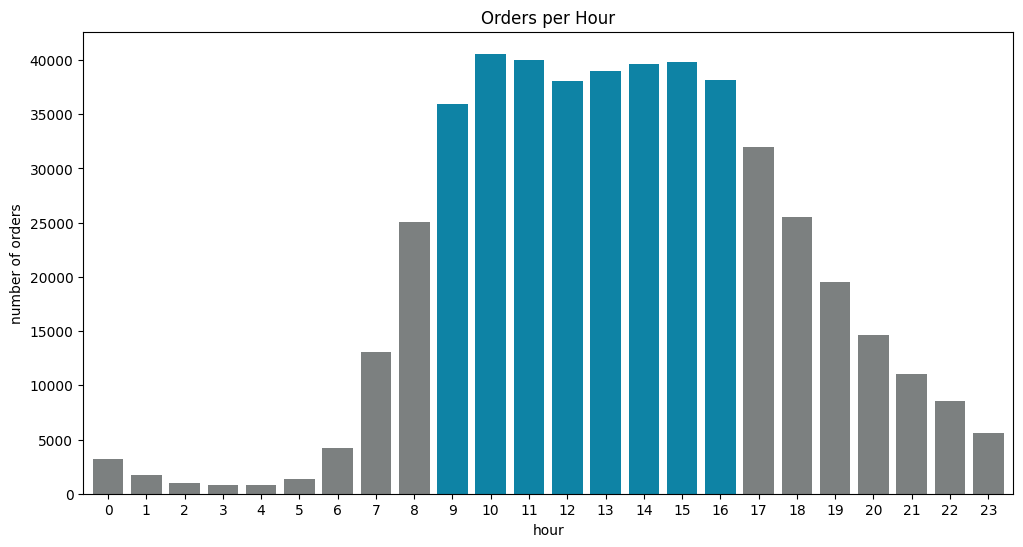

In [36]:
orders_per_hour = orders.groupby('order_hour_of_day').size().reset_index()
orders_per_hour.columns = ['hour', 'orders_cnt']
orders_per_hour['peak_orders'] = orders_per_hour['orders_cnt'] > 35000

orders_per_hour.plot(kind='bar',
                     title='Orders per Hour',
                     x='hour',
                     y='orders_cnt',
                     xlabel='hour',
                     ylabel='number of orders',
                     width=0.8,
                     color=orders_per_hour['peak_orders'].map({True : '#0E83A5', False : '#7C8080'}),
                     legend=False,
                     rot=0,
                     figsize=(12,6)
                    )
plt.show()

The chart reveals that the majority of the orders are placed between 9:00 and 16:00. Let's see how many distinct user ids place at least one order in each hour.

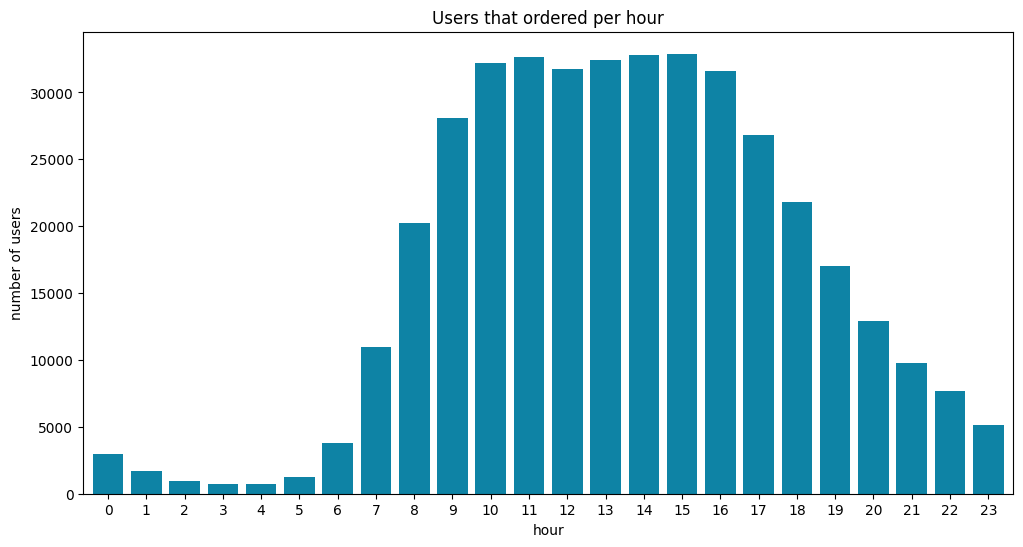

In [37]:
users_per_hour = orders.groupby('order_hour_of_day')['user_id'].nunique()
users_per_hour.plot(kind='bar',
                    title='Users that ordered per hour',
                    xlabel='hour',
                    ylabel='number of users',
                    width=0.8,
                    color='#0E83A5',
                    rot=0,
                    figsize=(12,6)
                   )
plt.show()

The distribution of both the number of orders and the count of distinct users placing orders per hour appears similar. This suggests that users tend to place orders around the same times throughout the day.

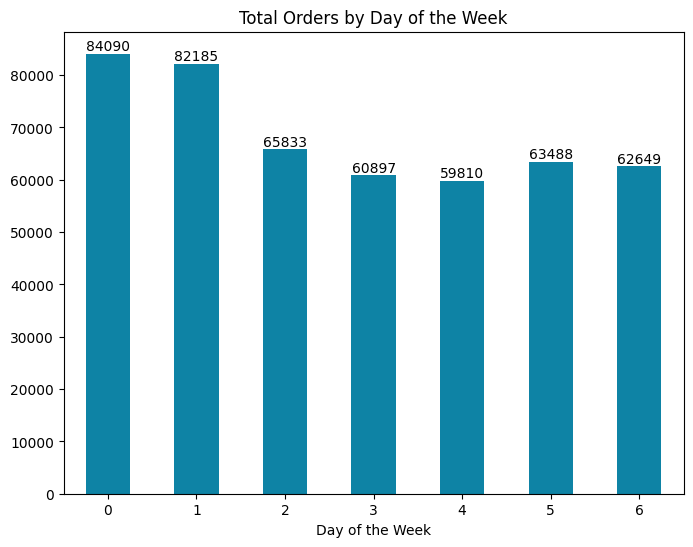

In [38]:
orders_per_day = orders['order_dow'].value_counts().sort_index()
orders_per_day.plot(kind='bar', color='#0E83A5', figsize=(8,6), rot=0)
plt.title('Total Orders by Day of the Week')
plt.xlabel('Day of the Week')

for i, val in enumerate(orders_per_day):
    plt.annotate(str(val), xy=(i, val), ha='center', va='bottom')

plt.show()

We do not have explicit information indicating which number corresponds to each day of the week, and it is not possible to determine based on the data available alone.  However, by examining the count of orders per day, we can make an assumption that 0 represents Sunday, as it is the day with the highest number of orders, and Sundays are commonly associated with grocery shopping. Additionally, in systems where days of the week are represented by numbers ranging from 0 to 6, conventionally, 0 corresponds to Sunday, 1 to Monday, and so on. Under that assumption, we can see that Sunday and Monday have a significantly higher number of orders than the rest of the week, while the number of orders remains relatively constant for those day. 

<Axes: title={'center': 'Days Between Orders'}, xlabel='num of days', ylabel='frequency'>

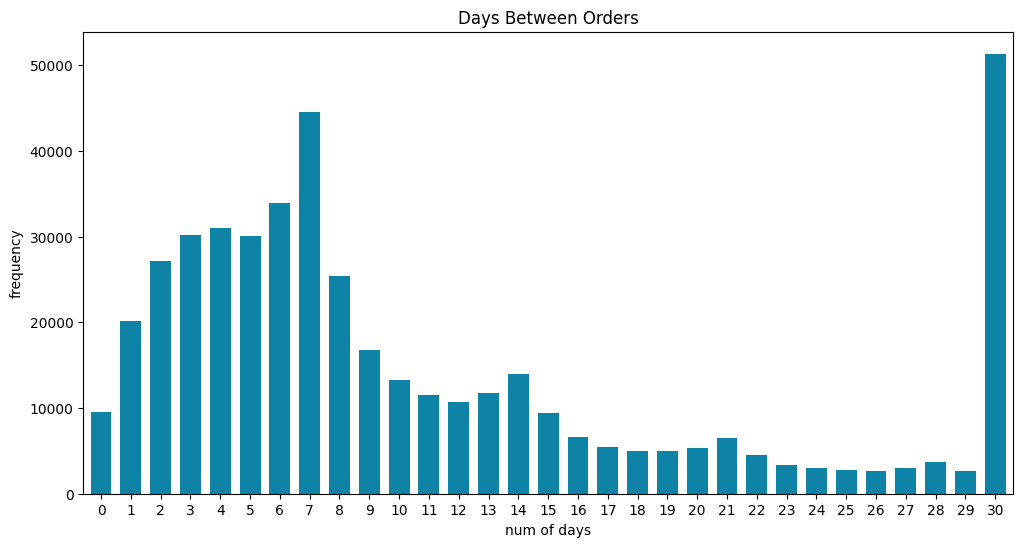

In [39]:
days_to_order = orders.groupby('days_since_prior_order')['order_id'].count()

days_to_order.plot(kind='bar',
                   title='Days Between Orders',
                   xlabel='num of days',
                   ylabel='frequency',
                   color='#0E83A5',
                   width=0.7,
                    rot=0,
                    figsize=(12,6)
                  )

The graph shows that most people  opt for either monthly intervals (30 days) or weekly intervals (7 days) between placing orders. Additionally,  a significant number of orders occur within a week (ranging from 0 to 6 days), suggesting that a portion of customers prefer more frequent restocking of groceries, possibly to ensure freshness of the products or to avoid spoiling items. Further analysis could explore whether customers who wait between 22-29 days between orders tend to purchase certain kinds of products, such as personal care items, pets, or household items, as opposed to food.

### 2.2 Part 2
Let's see if there a difference in `'order_hour_of_day'` distributions on Wednesdays and Saturdays.

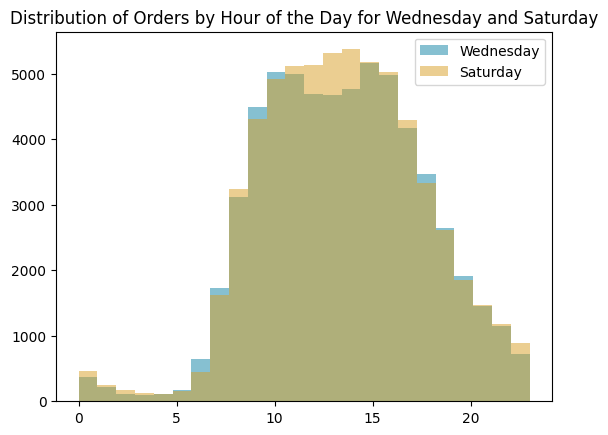

In [40]:
# Wednesday = 3, Saturday = 6
wed_orders = orders[(orders['order_dow'] == 3)]
sat_orders = orders[(orders['order_dow'] == 6)]
,
plt.hist(wed_orders['order_hour_of_day'], bins=24, alpha=0.5, label='Wednesday',color='#0E83A5')
plt.hist(sat_orders['order_hour_of_day'], bins=24, alpha=0.5, label='Saturday', color='#D89F25')
plt.title('Distribution of Orders by Hour of the Day for Wednesday and Saturday')
plt.legend()

plt.show()

The distribution for both days are very similar, with the only exception that Saturday present a higher number of orders between 12:00 and 15:00. Since we want to compare the difference in the number of orders for each hour, it might be useful to visualize it differently.

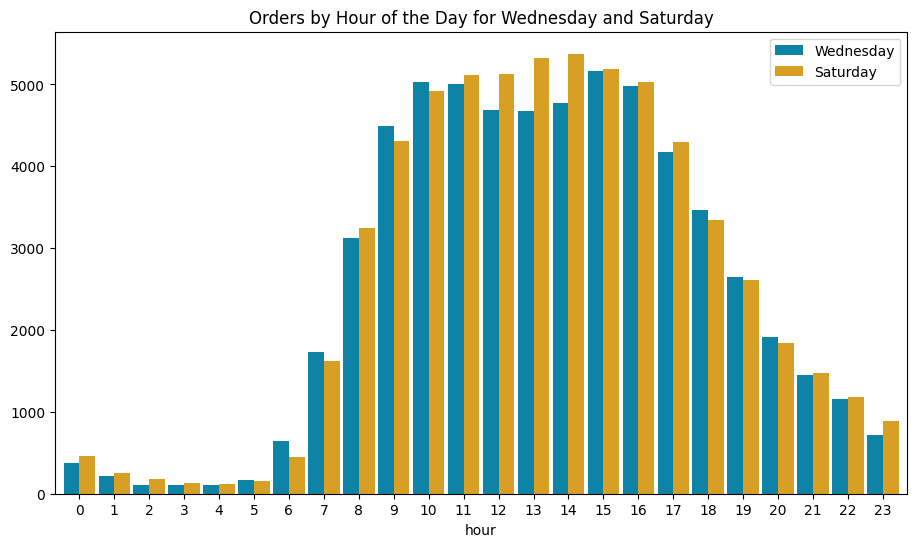

In [41]:
wed_orders = orders[(orders['order_dow'] == 3)]
sat_orders = orders[(orders['order_dow'] == 6)]

wed_orders_cnt = wed_orders['order_hour_of_day'].value_counts().sort_index()
sat_orders_cnt = sat_orders['order_hour_of_day'].value_counts().sort_index()

wed_sat_orders = pd.concat([wed_orders_cnt, sat_orders_cnt],
                          axis=1
                          )

wed_sat_orders.columns = ['Wednesday', 'Saturday']
wed_sat_orders.plot(kind='bar',
                   title= 'Orders by Hour of the Day for Wednesday and Saturday',
                    width=0.9,
                    xlabel='hour',
                    legend=True,
                    color={'Wednesday' : '#0E83A5', 'Saturday' : '#D89F25' },
                     rot=0,
                     figsize=(11,6)
                   )

plt.show()

Now let's explore the number of orders that customers place.

The customer with more orders has made 28 orders.


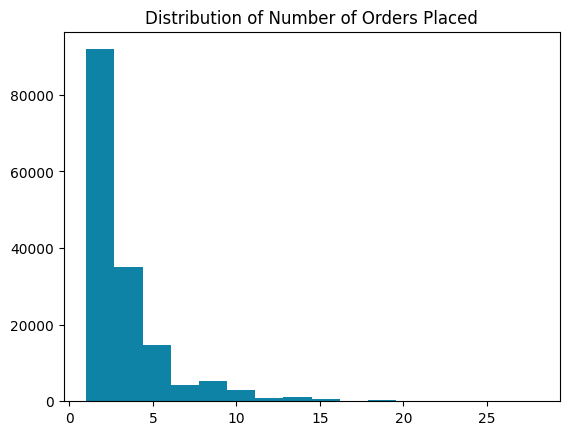

In [42]:
# Number of orders per customer
orders_per_customer = orders.groupby('user_id')['order_id'].count()
print('The customer with more orders has made', max(orders_per_customer), 'orders.')

plt.hist(orders_per_customer, bins = 16,color='#0E83A5')
plt.title('Distribution of Number of Orders Placed')
plt.show()

Very few customers had made more than 10 orders. Let's see the exact number of customers that placed between 1 and 10 orders.

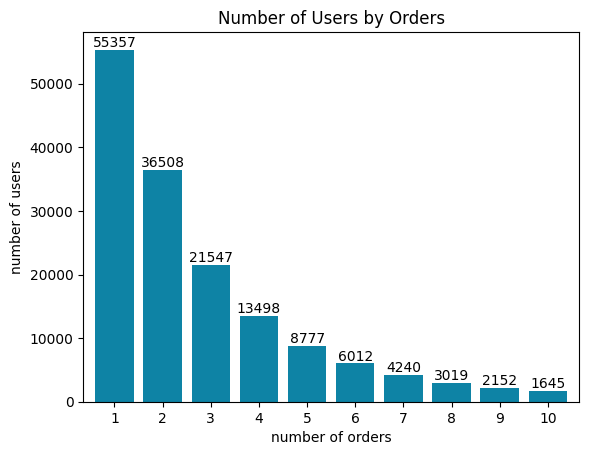

In [43]:
up_to_ten = orders_per_customer[orders_per_customer <= 10].sort_values().reset_index()
up_to_ten.columns = (['user_id', 'num_orders'])
up_to_ten = up_to_ten.groupby('num_orders')['user_id'].count()

up_to_ten.plot(kind='bar',
              title='Number of Users by Orders',
               xlabel='number of orders',
               ylabel='number of users',
               color='#0E83A5',
               width=0.8,
               rot=0
              )

for i, val in enumerate(up_to_ten):
    plt.annotate(str(val), xy=(i, val), ha='center', va='bottom')

plt.show()

Let's explore what are the most frequently ordered products.

In [44]:
# Top 20 ordered products
products_freq = order_products.groupby('product_id').size().sort_values(ascending=False)
top_20 = products_freq.head(20)
top_20 = top_20.reset_index()
top_20.columns = ['product_id', 'frequency']

top_20_products = pd.merge(top_20, products, on='product_id')
top_20_products = top_20_products[['product_id', 'product_name', 'frequency']]
top_20_products

,product_id,product_name,frequency
0,24852,Banana,66050
1,13176,Bag of Organic Bananas,53297
2,21137,Organic Strawberries,37039
3,21903,Organic Baby Spinach,33971
4,47209,Organic Hass Avocado,29773
5,47766,Organic Avocado,24689
6,47626,Large Lemon,21495
7,16797,Strawberries,20018
8,26209,Limes,19690
9,27845,Organic Whole Milk,19600


### 2.3 Part 3

Let's see the distribution of how many items people typically buy in one order. 

In [45]:
products_per_order = order_products.groupby('order_id')['product_id'].count()
products_per_order = products_per_order.reset_index()
products_per_order.columns=['order_id', 'products_cnt']

products_per_order = products_per_order.sort_values(by='products_cnt')
products_per_order.sample(10)

,order_id,products_cnt
66135,1451306,9
55506,1379907,47
207017,2413223,7
88265,1603321,7
109616,1747778,9
176887,2207208,3
88521,1604933,3
345787,3365665,29
366762,430605,1
306911,3098432,17


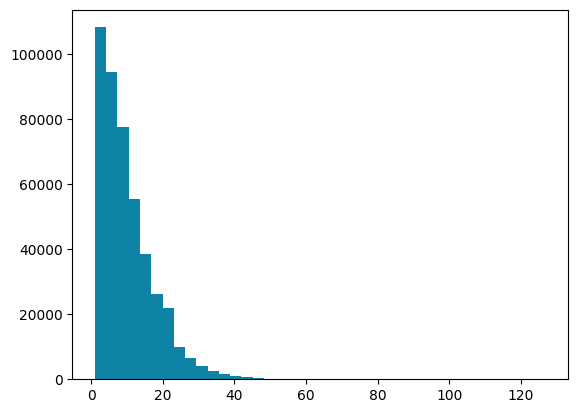

In [46]:
plt.hist(products_per_order['products_cnt'], bins = 40, color='#0E83A5')
plt.show()

It appears that there are some outliers on the right end of the distribution. Given that the histogram shows a right-skewed distribution, we'll proceed by removing the outliers only on the upper end.

In [47]:
# Calculate the interquartile range (IQR)
# We're using 10th and 90th percentile instead of 25th and 75th, 
# to adjust the sensitivity of the detection of ouliers. 
# Using 25th and 75th percentile excludes values that do not seem to be outliers.
Q1 = products_per_order['products_cnt'].quantile(0.10)
Q3 = products_per_order['products_cnt'].quantile(0.90)
IQR = Q3 - Q1

# Define the upper bound for outliers 
upper_bound = Q3 + 1.5 * IQR

products_per_order_filtered = products_per_order[products_per_order['products_cnt'] < upper_bound]
products_per_order_filtered.head()

,order_id,products_cnt
331192,3266022,1
115509,1788560,1
115515,1788597,1
115521,1788637,1
23995,1164076,1


In [48]:
print('The mean of the number of products bought per order is', products_per_order_filtered['products_cnt'].mean())
print('The median of the number of products bought per order is', products_per_order_filtered['products_cnt'].median())

The mean of the number of products bought per order is 10.023809364823927
The median of the number of products bought per order is 8.0


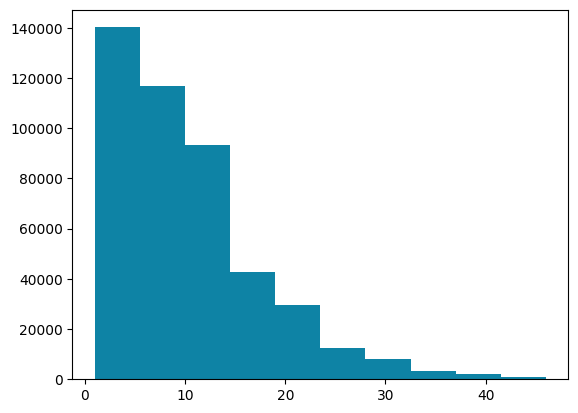

In [49]:
plt.hist(products_per_order_filtered['products_cnt'], bins = 10, color='#0E83A5');

The average number of products is approximately 10, with a median of 8 products. In the histogram, the highest concentration of orders is observed for quantities up to around 15 items. Beyond this point, the frequency sharply declines. This suggests that a significant proportion of orders are placed for individuals or small households, rather than for larger families that might require larger quantities of products per order. Alternatively, this might indicate that customers might also use alternative methods to supplement their groceries needs (i.e. customers might not buy everything they need through the app).

This, aligned with the previous observation of frequency of orders, might indicate that customers that tend to place a following order after one week or one month may have specific preference when it comes to the products offered in via the app. Let's continue exploring what are the items that are reordered most frequently.

In [50]:
reordered_products = order_products[order_products['reordered'] == 1]
reordered_products.sample(5)

,order_id,product_id,add_to_cart_order,reordered
1862420,3042734,44632,25.0,1
584133,779889,29672,1.0,1
2721223,1104788,16714,2.0,1
2375712,2333828,24184,11.0,1
3221665,3412685,44359,2.0,1


In [51]:
top_20_reordered = reordered_products.groupby('product_id')['reordered'].sum().sort_values(ascending=False)
top_20_reordered = top_20_reordered.reset_index().head(20)
top_20_reordered.columns= ['product_id', 'times_reordered']

top_20_products_reordered = pd.merge(top_20_reordered, products, on='product_id')
top_20_products_reordered = top_20_products_reordered[['product_id', 'product_name', 'times_reordered', 'department_id']]

In [52]:
top_20_dep = top_20_products_reordered.merge(departments,
                                            on='department_id')
top_20_dep.drop('department_id', axis=1, inplace=True)
top_20_dep

,product_id,product_name,times_reordered,department
0,24852,Banana,55763,produce
1,13176,Bag of Organic Bananas,44450,produce
2,21137,Organic Strawberries,28639,produce
3,21903,Organic Baby Spinach,26233,produce
4,47209,Organic Hass Avocado,23629,produce
5,47766,Organic Avocado,18743,produce
6,47626,Large Lemon,15044,produce
7,27966,Organic Raspberries,14748,produce
8,16797,Strawberries,13945,produce
9,26209,Limes,13327,produce


Most of the products reordered are from the produce department, most of which are organic products. Now let's explore, for each product, what proportion of its orders are reorders.

In [53]:
# Count of times each item has been reordered.
reordered_items = order_products.loc[order_products['reordered'] == 1, ['product_id', 'reordered']]
reordered_items = reordered_items.groupby('product_id')['reordered'].count().reset_index()

# Count of times each item has been ordered.
ordered_items = order_products.groupby('product_id').size().reset_index(name='product_cnt')

# Calculate proportion of reordered products. Products that have not been reordered are not shown.
proportion_reordered = ordered_items.merge(reordered_items, on='product_id')
proportion_reordered.columns = (['product_id', 'times_ordered', 'times_reordered'])
proportion_reordered = proportion_reordered.merge(products, on='product_id')
proportion_reordered = proportion_reordered[['product_name', 'product_id', 'times_ordered', 'times_reordered']]
proportion_reordered['proportion'] = (proportion_reordered['times_reordered']/proportion_reordered['times_ordered'] * 100).round(2)
proportion_reordered.sort_values(by='times_ordered', ascending=False).head(20)

,product_name,product_id,times_ordered,times_reordered,proportion
12068,Banana,24852,66050,55763,84.43
2557,Bag of Organic Bananas,13176,53297,44450,83.40
9022,Organic Strawberries,21137,37039,28639,77.32
9656,Organic Baby Spinach,21903,33971,26233,77.22
30167,Organic Hass Avocado,47209,29773,23629,79.36
30627,Organic Avocado,47766,24689,18743,75.92
30514,Large Lemon,47626,21495,15044,69.99
5505,Strawberries,16797,20018,13945,69.66
13168,Limes,26209,19690,13327,67.68
14499,Organic Whole Milk,27845,19600,16251,82.91


For the top 20 products (most ordered), the reorder proportion is relatively high, ranging between 60% and 85%. As seen before, most of them are from the produce department, which might have a short shelf life. This observation aligns with the assumption that users tend to buy more frequently and reorder products that are likely to spoil faster. It suggests that customers prioritize restocking perishable items, such as fruits and vegetables, contributing to the high reorder rates observed for these products.

## 3. Conclusion

In summary, our analysis highlights several key insights regarding Instacart customer behavior:

- Customers tend to place orders primarily during daytime hours, with peaks observed between 9:00 and 16:00, suggesting consistent shopping patterns throughout the day.
- Most orders consist of approximately 8 to 10 items, with a notable decline in frequency beyond 15 items, indicating that many orders are placed for individuals or small households.
- The high reorder proportions, ranging from 60% to 85%, for the top 20 products (predominantly organic produce) suggest that customers prioritize restocking perishable items.
